# **depressed-Analysis**

The suicide rate of patients with depression has been increasing in recent years. We trained this model by analyzing 232,074 pieces of text data. It is a machine learning-based algorithm for text classification and a computational method for semantic sentiment analysis. The experimental results show that it can effectively predict the sentiment of depression patients' blog posts on social media such as Twitter or Facebook. This allows physicians to intervene in advance when a depressed patient attempts to harm himself.

Step 1: We are read the dataset called "depression_Detection"

In [44]:
import pandas as pd

In [45]:
data = pd.read_csv('Data/dataset2.csv')
print(data.head())

print()

   Unnamed: 0                                               text  class
0           1                                         oh my gosh    1.0
1           2  trouble sleeping, confused mind, restless hear...    1.0
2           3  All wrong, back off dear, forward doubt. Stay ...    1.0
3           4  I've shifted my focus to something else but I'...    1.0
4           5  I'm restless and restless, it's been a month n...    1.0



Step 2: Check the dataset

In [46]:
print(f"Data shape {data.shape}")

print(f"Number of Unique Elements: {len(data['text'].unique())}")

Data shape (6982, 3)
Number of Unique Elements: 6896


Step 3: The dataset is selected and divided into training set and testing set

In [47]:
from sklearn.model_selection import train_test_split

X = data.drop(labels=['class', 'Unnamed: 0' ], axis=1)
y = data['class'].map({0:"Not_Depressed_(Take_a_break)",1:"Depressed_(Share_with_us_/_Talk_to_Doctor)"})

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

Step 4: Perform feature extraction on the data of the training set. CountVectorizer is transform a given text into a vector on the basis of the count of each word that occurs in the entire text.

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(x_train['text'])

print(x_train_counts.shape)

print(f"vocab => {count_vect.vocabulary_.get(u'disaster')}")

(5236, 9745)
vocab => 2540


Step 5: Perform feature extraction on the data of the training set. Tfidftransformer will compute word counts using CountVectorizer and then compute the IDF values and only then compute the Tf-idf scores

In [49]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
X_train_tfidf.shape

(5236, 9745)

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

Step 6: To classification of feature vectors in training sets by naive Bayes algorithm

In [51]:
# Check for NaN values in the data
print("NaN values in each column of X:\n", X.isna().sum())
print("NaN values in y:", y.isna().sum())

# Handle NaN values - here, we'll impute NaN values with empty strings for text
X['text'] = X['text'].fillna('')

# Ensure y does not have NaN values (if it does, drop those rows)
X = X[y.notna()]
y = y[y.notna()]

# Check again for any NaN values after dropping rows
print("NaN values in each column of X after cleaning:\n", X.isna().sum())
print("NaN values in y after cleaning:", y.isna().sum())

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

# Convert text data to count vectors
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(x_train['text'])

print(x_train_counts.shape)
print(f"Vocabulary size: {len(count_vect.vocabulary_)}")

# Transform count vectors to TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

print(X_train_tfidf.shape)

# Ensure no NaN values in transformed features
if np.isnan(X_train_tfidf.data).sum() > 0:
    print("NaN values detected in X_train_tfidf, replacing with zeros.")
    X_train_tfidf.data = np.nan_to_num(X_train_tfidf.data)

# Train the Naive Bayes classifier
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# Verify with a sample prediction
sample_texts = ["I'm feeling very sad and depressed.", "I am so happy and joyful today!"]
sample_counts = count_vect.transform(sample_texts)
sample_tfidf = tfidf_transformer.transform(sample_counts)
predictions = clf.predict(sample_tfidf)

print(f"Predictions: {predictions}")

NaN values in each column of X:
 text    0
dtype: int64
NaN values in y: 2
NaN values in each column of X after cleaning:
 text    0
dtype: int64
NaN values in y after cleaning: 0
(5235, 9698)
Vocabulary size: 9698
(5235, 9698)
Predictions: ['Not_Depressed_(Take_a_break)' 'Not_Depressed_(Take_a_break)']


In [52]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

We try a little demo with two values to see if the model works

In [53]:
docs_new = ['I am confused, I am not feeling good lately. Every time I want to sleep, I always feel restless', 'I love KFC']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print(f'{doc} -> {category}')

I am confused, I am not feeling good lately. Every time I want to sleep, I always feel restless -> Not_Depressed_(Take_a_break)
I love KFC -> Not_Depressed_(Take_a_break)


Luckily, it does.

Step 7: Call fit() to train and predict the algorithm model in the pipeline

In [54]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

text_clf.fit(x_train['text'], y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

Step 8: Visualize confusion matrix to analyze the results of train

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
def print_confusion_matrix(model,
                           confusion_matrix,
                           figsize = (8,8),
                           fontsize=12,
                           ylabel='True label',
                           xlabel='Predicted label'):


    class_names = model.classes_
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)


accuracy:-> 0.8951289398280803
                                            precision    recall  f1-score   support

Depressed_(Share_with_us_/_Talk_to_Doctor)       1.00      0.09      0.16       201
              Not_Depressed_(Take_a_break)       0.89      1.00      0.94      1544

                                  accuracy                           0.90      1745
                                 macro avg       0.95      0.54      0.55      1745
                              weighted avg       0.91      0.90      0.85      1745



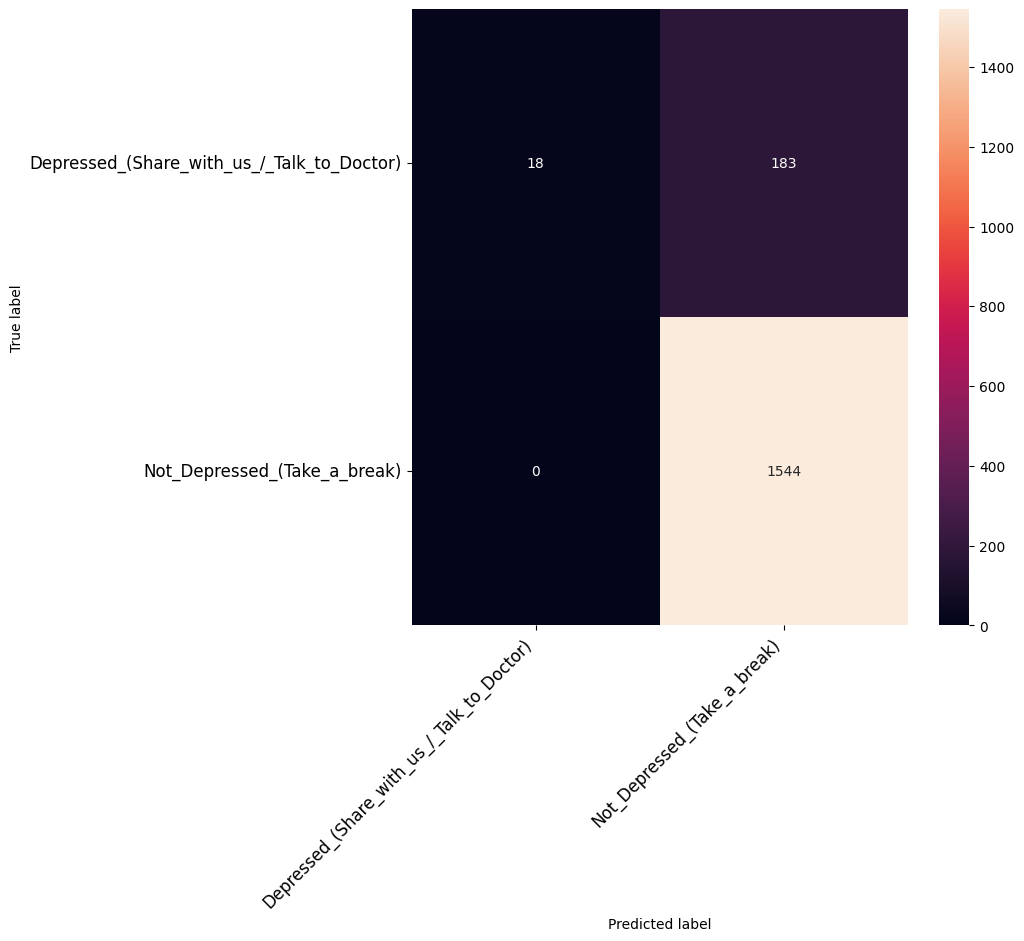

In [56]:
print(f"accuracy:-> {text_clf.score(x_test['text'],y_test)}")


from sklearn import metrics

docs_test = x_test['text']
predicted = text_clf.predict(docs_test)

print(metrics.classification_report(y_test, predicted ))

# print(metrics.confusion_matrix(y_test, predicted))

cm = metrics.confusion_matrix(y_test, predicted, labels=text_clf.classes_)

print_confusion_matrix(text_clf,confusion_matrix=cm)

Step 9: Classify data using stochastic gradient descent

In [57]:
from sklearn.linear_model import SGDClassifier
text_clf2 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=.0001, random_state=42,
                          max_iter=5, tol=None)),
])




Step 10: Visualize the results of stochastic gradient descent classification

accuracy:-> 0.9851002865329513
                                            precision    recall  f1-score   support

Depressed_(Share_with_us_/_Talk_to_Doctor)       0.95      0.92      0.93       201
              Not_Depressed_(Take_a_break)       0.99      0.99      0.99      1544

                                  accuracy                           0.99      1745
                                 macro avg       0.97      0.95      0.96      1745
                              weighted avg       0.98      0.99      0.98      1745



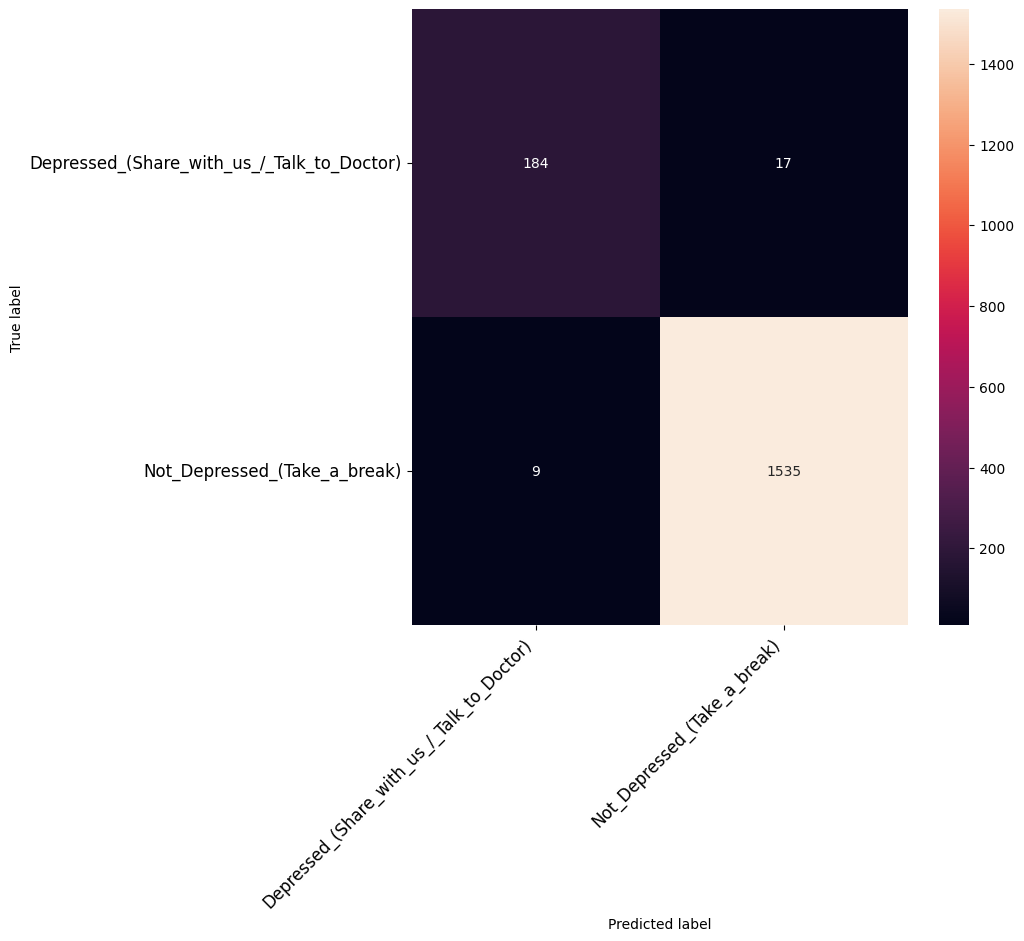

In [58]:
text_clf2.fit(x_train['text'], y_train)

predicted = text_clf2.predict(docs_test)
print (f"accuracy:-> {text_clf2.score(x_test['text'],y_test)}")


print(metrics.classification_report(y_test, predicted ))
# print(metrics.confusion_matrix(y_test, predicted))


cm = metrics.confusion_matrix(y_test, predicted, labels=text_clf2.classes_)

print_confusion_matrix(text_clf2,confusion_matrix=cm)

We Thereby can see that **text_clf2** gives us a better prediction. So we use it as out model of choice

In [59]:
best_model = text_clf2

We then export the model as an `.sav` file and use it for our web application as you will see. We have decided to use streamlit for easy of use.

In [60]:
import joblib

filename = 'finalized_model.sav'
joblib.dump(best_model, filename)

['finalized_model.sav']